<a href="https://colab.research.google.com/github/tiwarikaran/Deit/blob/main/PyTorch_DeiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
pip install timm

     |████████████████████████████████| 245kB 13.3MB/s 


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms  
from torch.utils.data.sampler import SubsetRandomSampler  
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import torch.nn.functional as F
import os

from tqdm import tqdm
import tqdm.notebook as tq

import time
import json
import copy
import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

import timm


# Basic

In [22]:
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(220),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]);type(data_transform)

torchvision.transforms.transforms.Compose

In [23]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data/train',
                                           transform=data_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=4,
                                             shuffle=True,
                                             num_workers=8)

In [ ]:
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/data/valid',
                                           transform=data_transform)

In [ ]:
val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=4,
                                             shuffle=True,
                                             num_workers=8)

In [21]:
train_dataset

NameError: ignored

In [ ]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    break

tensor([1, 0, 1, 1])
torch.Size([4, 3, 220, 220])


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is can be set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to('cpu')

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Rough Work

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.train(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [ ]:
fit(2,.001, model_ft, train_loader,val_loader)

# ADV

In [44]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
type(data_transforms)

dict

In [5]:
data_dir = '/content/drive/MyDrive/data'

In [45]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'valid']}

In [ ]:
image_datasets['train'].class_to_idx 

{'meme': 0, 'not_meme': 1}

In [7]:
image_datasets['train'],image_datasets['valid']

(Dataset ImageFolder
     Number of datapoints: 400
     Root location: /content/drive/MyDrive/data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), Dataset ImageFolder
     Number of datapoints: 180
     Root location: /content/drive/MyDrive/data/valid
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [46]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)
print('----------------------------')
class_names = image_datasets['train'].classes
print(class_names)
print('----------------------------')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'train': 400, 'valid': 180}
----------------------------
['meme', 'not_meme']
----------------------------
cuda:0


In [ ]:
torch.cuda.is_available()

True

In [27]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
!nvidia-smi

Thu Jan 14 21:31:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
 ! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [31]:
inputs, classes = next(iter(dataloaders['train']))

In [32]:
inputs.shape,classes.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [35]:
out = torchvision.utils.make_grid(inputs);out.shape

torch.Size([3, 906, 1810])

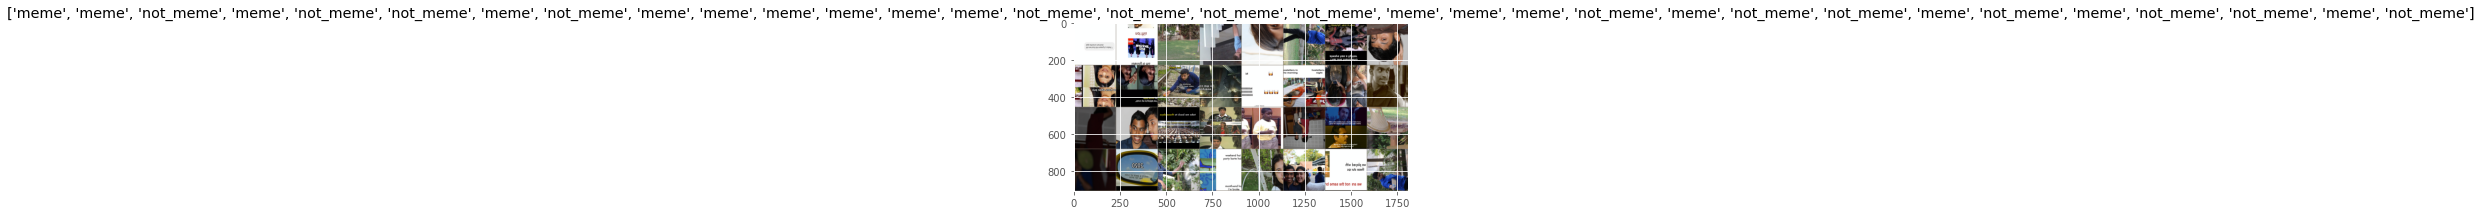

In [36]:
imshow(out,[class_names[x] for x in classes])

Define Train Model

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [38]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [39]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


In [ ]:
model

In [53]:
model.head  =  nn.Sequential(nn.Linear(768, 1024),
                             nn.Dropout(0.2),
                             nn.ReLU(),
                             nn.Linear(1024, 512),
                             nn.Dropout(0.2),
                             nn.ReLU(),
                             nn.Linear(512, 2)
                             )

In [58]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 1 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


In [60]:
model_deit = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs= 3)

Epoch 1/3
----------
train Loss: 0.0540 Acc: 0.9825
valid Loss: 0.0067 Acc: 1.0000

Epoch 2/3
----------
train Loss: 0.0723 Acc: 0.9825
valid Loss: 0.0159 Acc: 1.0000

Epoch 3/3
----------
train Loss: 0.0398 Acc: 0.9850
valid Loss: 0.0344 Acc: 0.9889

Training complete in 5m 4s
Best val Acc: 1.000000


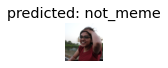

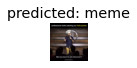

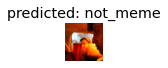

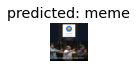

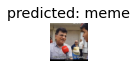

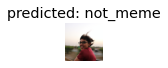

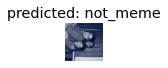

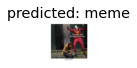

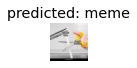

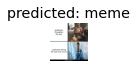

In [62]:
visualize_model(model_deit)